<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D1%80_4_%D1%82%D0%BE%D1%87%D0%B5%D1%87%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пример 4-точечного преобразования OpenCV

# OpenCV 4-point transform example

В этом уроке я мы сделаем перспективное преобразование для получения изображения сверху вниз, «с высоты птичьего полета».

In this tutorial I will do a perspective transformation to get a top-down, bird's-eye view.

### Загрузка файлов
### Download the code zip file

In [2]:
!wget http://dataudt.ru/datasets/cv/Lesson_22.perspective_transform.zip
!unzip -qq Lesson_22.perspective_transform.zip
%cd /content/Lesson_22.perspective_transform/

--2022-02-09 07:20:02--  http://dataudt.ru/datasets/cv/Lesson_22.perspective_transform.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22345307 (21M) [application/zip]
Saving to: ‘Lesson_22.perspective_transform.zip’

Lesson_22.perspecti 100%[===================>]  21.31M  10.5MB/s    in 2.0s    

2022-02-09 07:20:05 (10.5 MB/s) - ‘Lesson_22.perspective_transform.zip’ saved [22345307/22345307]

/content/Lesson_22.perspective_transform


### Импорт библиотек
### Import Packages

In [3]:
# импортируем необходимые библиотеки
# import the necessary packages
from matplotlib import pyplot as plt
import numpy as np
import cv2

### Функция отображения изображений в Jupyter Notebooks и Google Colab

### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
    # конвертируем изображение из формата BGR в RGB и отображаем его 
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Функции преобразования

### Transform functions

In [5]:
def order_points(pts):
    # создаем список координат, которые будут упорядочены
	# таким образом, чтобы первая запись в списке находилась в верхнем левом углу,
	# вторая запись находится справа вверху, третья -
	# в нижнем правом, а четвертая - в нижнем левом
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
    # в верхней левой точке будет наименьшая сумма, тогда как
	# в правой нижней точке будет наибольшая сумма
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

    # теперь вычислим разницу между точками,
	# верхняя правая точка будет иметь наименьшее различие,
	# тогда как в нижнем левом углу будет наибольшая разница
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	
    # возвращаем упорядоченные координаты
	# return the ordered coordinates
	return rect

In [6]:
def four_point_transform(image, pts):
    # получаем согласованный порядок точек и отдельно распаковываем их
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

    # вычисляем ширину нового изображения, которое будет
	# максимальным расстоянием между нижней правой и нижней левой
	# x-координатами или верхней правой и верхней левой x-координатами
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

    # вычисляем высоту нового изображения, которая будет
	# максимальным расстоянием между верхней правой и нижней правой
	# y-координатами или верхней левой и нижней левой координатами y
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

    # теперь, когда у нас есть размеры нового изображения, создадим
	# набор точек для просмотра "с высоты птичьего полета",
	# (т.е. вид сверху вниз) изображения, опять же с указанием точек
	# в верхнем левом, верхнем правом, нижнем правом и нижнем левом углах
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

    # вычисляем матрицу перспективного преобразования и затем применяем ее
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # возвращаем деформированное изображение
	# return the warped image
	return warped

### Пример 4-точечного OpenCV getPerspectiveTransform
### 4 Point OpenCV getPerspectiveTransform Example

In [9]:
# явно укажем аргументы необходимые для работы
# image - путь к изображению 
# coords - список исходных точек, разделенных запятыми

# explicitly specify the arguments needed to work
# image - image path
# coords - comma seperated list of source points
args = {
	"image": "images/example_03.png",
	"coords": "[(605, 681), (405, 2390), (2258,692), (2338, 2418)]"
}

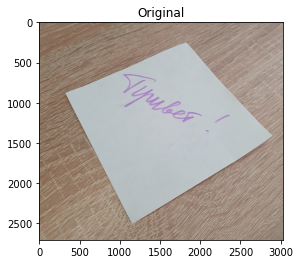

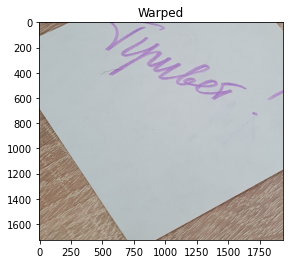

In [10]:
# загружаем изображение и получаем исходные координаты (т.е. список из (x, y) точек)
# ВНИМАНИЕ: использование функции eval - плохой тон, но в этом примере
# мы воспользуемся ей - в следующих уроках мы узнаем, как
# автоматически определять координаты без их предварительного ввода
# load the image and grab the source coordinates (i.e. the list of
# of (x, y) points)
# NOTE: using the 'eval' function is bad form, but for this example
# let's just roll with it -- in future posts I'll show you how to
# automatically determine the coordinates without pre-supplying them
image = cv2.imread(args["image"])
pts = np.array(eval(args["coords"]), dtype = "float32")

# применяем четырехточечное преобразование, чтобы получить вид изображения "с высоты птичьего полета" 
# apply the four point tranform to obtain a "birds eye view" of
# the image
warped = four_point_transform(image, pts)

# показываем исходное и деформированное изображения
# show the original and warped images
plt_imshow("Original", image)
plt_imshow("Warped", warped)